In [1]:
import random
import pickle
import torch

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

from collections import defaultdict

from causal_gym import HighwayPCH
from imitation.imitate import *

In [2]:
num_steps     = 100
train_eps     = 1000
seed          = 1

# reproducibility
random.seed(seed)
torch.manual_seed(seed)

In [3]:
env = HighwayPCH(num_steps=num_steps, seed=seed, render_mode='rgb_array')

In [4]:
G = parse_graph(*env.env.get_graph)
X = {f'X{t}' for t in range(num_steps)}
Y = f'Y{num_steps}'
obs_prefix = env.env.observed_unobserved_vars[0]

In [5]:
Z_sets = find_sequential_pi_backdoor(G, X, Y, obs_prefix)
Z_sets

{'X51': {'A0',
  'A1',
  'A10',
  'A11',
  'A12',
  'A13',
  'A14',
  'A15',
  'A16',
  'A17',
  'A18',
  'A19',
  'A2',
  'A20',
  'A21',
  'A22',
  'A23',
  'A24',
  'A25',
  'A26',
  'A27',
  'A28',
  'A29',
  'A3',
  'A30',
  'A31',
  'A32',
  'A33',
  'A34',
  'A35',
  'A36',
  'A37',
  'A38',
  'A39',
  'A4',
  'A40',
  'A41',
  'A42',
  'A43',
  'A44',
  'A45',
  'A46',
  'A47',
  'A48',
  'A49',
  'A5',
  'A50',
  'A51',
  'A6',
  'A7',
  'A8',
  'A9',
  'B0',
  'B1',
  'B10',
  'B11',
  'B12',
  'B13',
  'B14',
  'B15',
  'B16',
  'B17',
  'B18',
  'B19',
  'B2',
  'B20',
  'B21',
  'B22',
  'B23',
  'B24',
  'B25',
  'B26',
  'B27',
  'B28',
  'B29',
  'B3',
  'B30',
  'B31',
  'B32',
  'B33',
  'B34',
  'B35',
  'B36',
  'B37',
  'B38',
  'B39',
  'B4',
  'B40',
  'B41',
  'B42',
  'B43',
  'B44',
  'B45',
  'B46',
  'B47',
  'B48',
  'B49',
  'B5',
  'B50',
  'B51',
  'B6',
  'B7',
  'B8',
  'B9',
  'D0',
  'D1',
  'D10',
  'D11',
  'D12',
  'D13',
  'D14',
  'D15',
  'D16'

In [6]:
records = collect_expert_trajectories(
    env,
    num_episodes=train_eps,
    max_steps=num_steps,
    behavioral_policy=None,
    seed=seed
)

Starting episode 1/1000...
  Episode 1 ended at step 11 (terminated: True, truncated: False).
Starting episode 2/1000...
  Episode 2 ended at step 100 (terminated: False, truncated: True).
Starting episode 3/1000...
  Episode 3 ended at step 22 (terminated: True, truncated: False).
Starting episode 4/1000...
  Episode 4 ended at step 92 (terminated: True, truncated: False).
Starting episode 5/1000...
  Episode 5 ended at step 10 (terminated: True, truncated: False).
Starting episode 6/1000...
  Episode 6 ended at step 100 (terminated: False, truncated: True).
Starting episode 7/1000...
  Episode 7 ended at step 17 (terminated: True, truncated: False).
Starting episode 8/1000...
  Episode 8 ended at step 32 (terminated: True, truncated: False).
Starting episode 9/1000...
  Episode 9 ended at step 32 (terminated: True, truncated: False).
Starting episode 10/1000...
  Episode 10 ended at step 33 (terminated: True, truncated: False).
Starting episode 11/1000...
  Episode 11 ended at step 7

In [7]:
with open('expert_traj.pkl', 'wb') as f:
    pickle.dump(records, f)

print(f'saved {len(records)} trajectories')

saved 53491 trajectories


In [8]:
with open('expert_traj.pkl', 'rb') as f:
    records = pickle.load(f)

print(f'loaded {len(records)} trajectories')

loaded 53491 trajectories


In [9]:
naive_Z_sets = {}
for Xi in X:
    i = int(Xi[1:])
    cond = set()

    for j in range(i+1):
        cond.update({f'D{j}', f'L{j}', f'A{j}', f'B{j}', f'W{j}'})

    for j in range(i):
        cond.add(f'X{j}')
    naive_Z_sets[Xi] = cond

In [10]:
causal_policies = train_policies(env, records, Z_sets, seed=seed, patience=20)
naive_policies = train_policies(env, records, naive_Z_sets, seed=seed, patience=20)

Stopping early at epoch 56; val_loss has not improved for 20 epochs.
Stopping early at epoch 95; val_loss has not improved for 20 epochs.
Stopping early at epoch 43; val_loss has not improved for 20 epochs.
Stopping early at epoch 69; val_loss has not improved for 20 epochs.
Stopping early at epoch 57; val_loss has not improved for 20 epochs.
Stopping early at epoch 35; val_loss has not improved for 20 epochs.
Stopping early at epoch 91; val_loss has not improved for 20 epochs.
Stopping early at epoch 51; val_loss has not improved for 20 epochs.
Stopping early at epoch 27; val_loss has not improved for 20 epochs.
Stopping early at epoch 36; val_loss has not improved for 20 epochs.
Stopping early at epoch 55; val_loss has not improved for 20 epochs.
Stopping early at epoch 44; val_loss has not improved for 20 epochs.
Stopping early at epoch 27; val_loss has not improved for 20 epochs.
Stopping early at epoch 66; val_loss has not improved for 20 epochs.
Stopping early at epoch 65; val_lo

Evaluating episode 1/1000...
Evaluating episode 2/1000...
Evaluating episode 3/1000...
Evaluating episode 4/1000...
Evaluating episode 5/1000...
Evaluating episode 6/1000...
Evaluating episode 7/1000...
Evaluating episode 8/1000...
Evaluating episode 9/1000...
Evaluating episode 10/1000...
Evaluating episode 11/1000...
Evaluating episode 12/1000...
Evaluating episode 13/1000...
Evaluating episode 14/1000...
Evaluating episode 15/1000...
Evaluating episode 16/1000...
Evaluating episode 17/1000...
Evaluating episode 18/1000...
Evaluating episode 19/1000...
Evaluating episode 20/1000...
Evaluating episode 21/1000...
Evaluating episode 22/1000...
Evaluating episode 23/1000...
Evaluating episode 24/1000...
Evaluating episode 25/1000...
Evaluating episode 26/1000...
Evaluating episode 27/1000...
Evaluating episode 28/1000...
Evaluating episode 29/1000...
Evaluating episode 30/1000...
Evaluating episode 31/1000...
Evaluating episode 32/1000...
Evaluating episode 33/1000...
Evaluating episode 

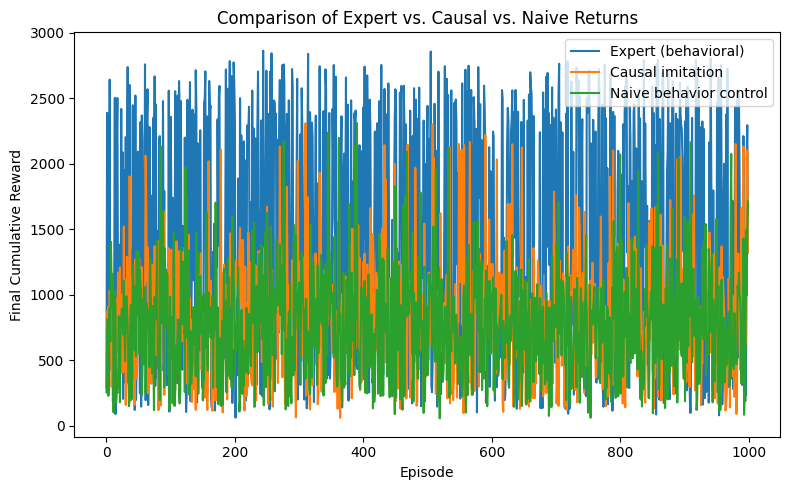

In [11]:
episode_rewards = defaultdict(float)
for rec in records:
    ep = rec['episode']
    episode_rewards[ep] = rec['info']['Y'][-1]

num_eps = len(episode_rewards)

expert_rewards = [episode_rewards[e] for e in range(num_eps)]

causal_returns = eval_policy(env, causal_policies, num_episodes=num_eps, seed=seed)
naive_returns  = eval_policy(env, naive_policies,  num_episodes=num_eps, seed=seed)

causal_rewards = [ep['Y'][-1] for ep in causal_returns]
naive_rewards = [ep['Y'][-1] for ep in naive_returns]

plt.figure(figsize=(8,5))
plt.plot(expert_rewards, label='Expert (behavioral)')
plt.plot(causal_rewards,  label='Causal imitation')
plt.plot(naive_rewards,   label='Naive behavior control')
plt.xlabel('Episode')
plt.ylabel('Final Cumulative Reward')
plt.title('Comparison of Expert vs. Causal vs. Naive Returns')
plt.legend()
plt.tight_layout()
plt.show()

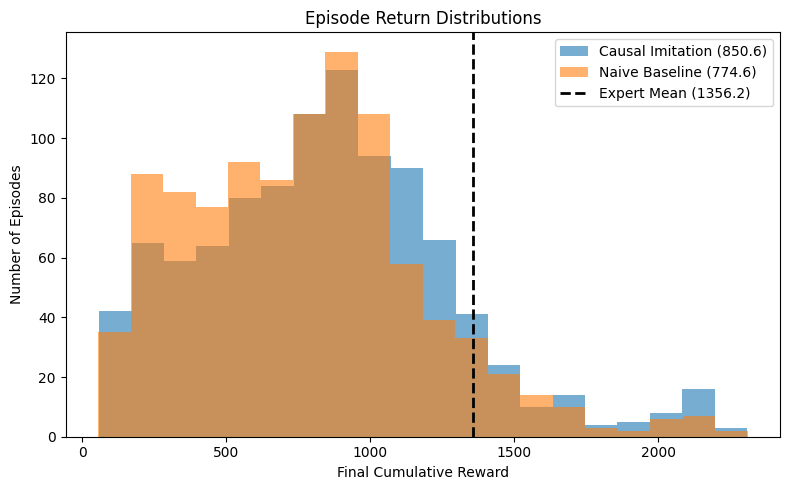

In [12]:
plt.figure(figsize=(8,5))
bins = 20  # number of histogram bins

expert_mean = np.mean(expert_rewards)
causal_mean = sum(causal_rewards) / len(causal_rewards)
naive_mean = sum(naive_rewards) / len(naive_rewards)

# plot histograms for causal and naive
plt.hist(causal_rewards, bins=bins, alpha=0.6, label=f'Causal Imitation ({causal_mean:.1f})')
plt.hist(naive_rewards,  bins=bins, alpha=0.6, label=f'Naive Baseline ({naive_mean:.1f})')

# compute and plot expert mean as a vertical line
plt.axvline(expert_mean, color='black', linestyle='--', linewidth=2, label=f'Expert Mean ({expert_mean:.1f})')

plt.xlabel('Final Cumulative Reward')
plt.ylabel('Number of Episodes')
plt.title('Episode Return Distributions')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
def policy_accuracy(records, policies):
    total, correct = 0, 0
    per_step = defaultdict(lambda: {'corr':0, 'total':0})

    for r in records:
        t = r['step']
        key = f'X{t}'
        if key not in policies:
            # no policy for this step—skip or count as incorrect
            continue
        pi_t = policies[key]
        pred = pi_t(r['obs'])
        true = r['action']

        per_step[t]['total']  += 1
        per_step[t]['corr']   += int(pred == true)
        total   += 1
        correct += int(pred == true)

    overall_acc = correct / total if total else float('nan')
    print(f"Overall accuracy: {overall_acc*100:.2f}% ({correct}/{total})")

    print("Per-step accuracy:")
    for t in sorted(per_step):
        ts = per_step[t]
        acc = ts['corr']/ts['total']
        print(f"  step {t}: {acc*100:.2f}% ({ts['corr']}/{ts['total']})")

    print()
    return overall_acc, per_step

# Example usage:
ci_acc, ci_step_acc = policy_accuracy(records, causal_policies)
bc_acc, bc_step_acc = policy_accuracy(records, naive_policies)

Overall accuracy: 91.64% (49019/53491)
Per-step accuracy:
  step 0: 100.00% (1000/1000)
  step 1: 99.70% (997/1000)
  step 2: 100.00% (1000/1000)
  step 3: 99.50% (993/998)
  step 4: 99.29% (982/989)
  step 5: 97.24% (953/980)
  step 6: 95.36% (925/970)
  step 7: 93.37% (887/950)
  step 8: 96.28% (906/941)
  step 9: 94.51% (878/929)
  step 10: 98.24% (894/910)
  step 11: 96.75% (864/893)
  step 12: 94.92% (840/885)
  step 13: 94.27% (823/873)
  step 14: 96.02% (821/855)
  step 15: 96.80% (818/845)
  step 16: 96.86% (802/828)
  step 17: 96.01% (771/803)
  step 18: 96.07% (757/788)
  step 19: 96.36% (742/770)
  step 20: 96.29% (726/754)
  step 21: 95.38% (702/736)
  step 22: 97.36% (702/721)
  step 23: 96.90% (687/709)
  step 24: 96.84% (675/697)
  step 25: 97.96% (671/685)
  step 26: 97.15% (648/667)
  step 27: 96.94% (633/653)
  step 28: 95.05% (615/647)
  step 29: 98.10% (620/632)
  step 30: 97.08% (599/617)
  step 31: 95.25% (581/610)
  step 32: 95.46% (568/595)
  step 33: 94.54% (55

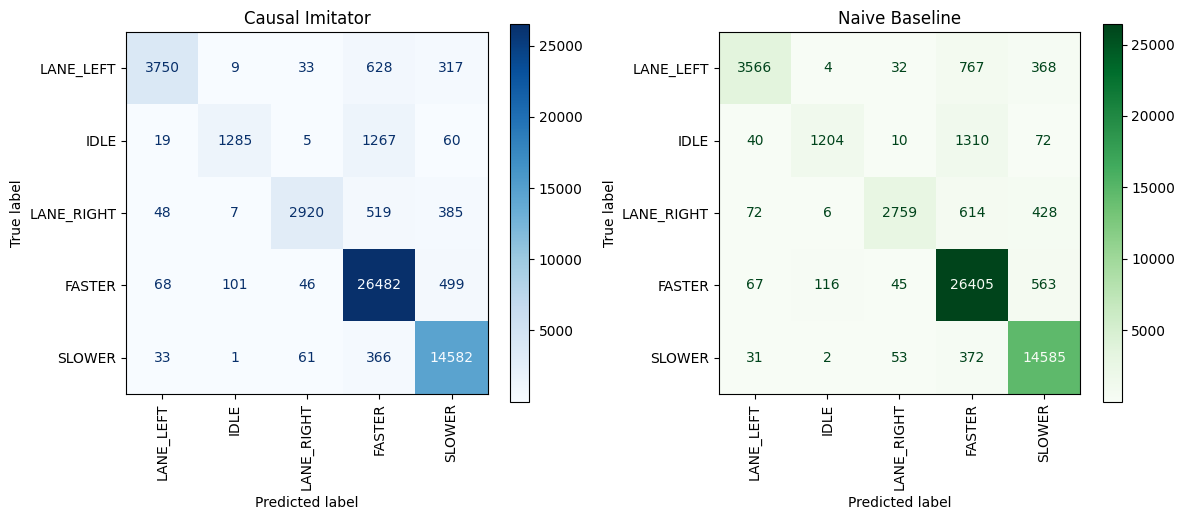

In [14]:
# Prepare label and display names
n_actions = env.env.action_space.n
labels = list(range(n_actions))
action_names = list(env.env.unwrapped.action_type.actions.keys())

# Gather true actions once
y_true = []
for r in records:
    y_true.append(r['action'])

# Gather predictions for causal and naive
y_pred_causal = []
y_pred_naive  = []
for r in records:
    t = r['step']
    key = f'X{t}'
    # causal
    if key in causal_policies:
        y_pred_causal.append(causal_policies[key](r['obs']))
    else:
        y_pred_causal.append(-1)  # or some placeholder
    # naive
    if key in naive_policies:
        y_pred_naive.append(naive_policies[key](r['obs']))
    else:
        y_pred_naive.append(-1)

# Compute confusion matrices (we’ll ignore the placeholder label -1)
cm_causal = confusion_matrix(y_true, y_pred_causal, labels=labels)
cm_naive  = confusion_matrix(y_true, y_pred_naive,  labels=labels)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

action_names = [env.env._meta_actions.ACTIONS_ALL[a] for a in action_names]

disp1 = ConfusionMatrixDisplay(cm_causal, display_labels=action_names)
disp1.plot(ax=ax1, cmap='Blues', xticks_rotation='vertical')
ax1.set_title("Causal Imitator")

disp2 = ConfusionMatrixDisplay(cm_naive, display_labels=action_names)
disp2.plot(ax=ax2, cmap='Greens', xticks_rotation='vertical')
ax2.set_title("Naive Baseline")

plt.tight_layout()
plt.show()

Starting episode 1/1000...
  Episode 1 ended at step 13 (terminated: True, truncated: False).
Starting episode 2/1000...
  Episode 2 ended at step 25 (terminated: True, truncated: False).
Starting episode 3/1000...
  Episode 3 ended at step 21 (terminated: True, truncated: False).
Starting episode 4/1000...
  Episode 4 ended at step 44 (terminated: True, truncated: False).
Starting episode 5/1000...
  Episode 5 ended at step 13 (terminated: True, truncated: False).
Starting episode 6/1000...
  Episode 6 ended at step 100 (terminated: False, truncated: True).
Starting episode 7/1000...
  Episode 7 ended at step 15 (terminated: True, truncated: False).
Starting episode 8/1000...
  Episode 8 ended at step 42 (terminated: True, truncated: False).
Starting episode 9/1000...
  Episode 9 ended at step 99 (terminated: True, truncated: False).
Starting episode 10/1000...
  Episode 10 ended at step 53 (terminated: True, truncated: False).
Starting episode 11/1000...
  Episode 11 ended at step 52

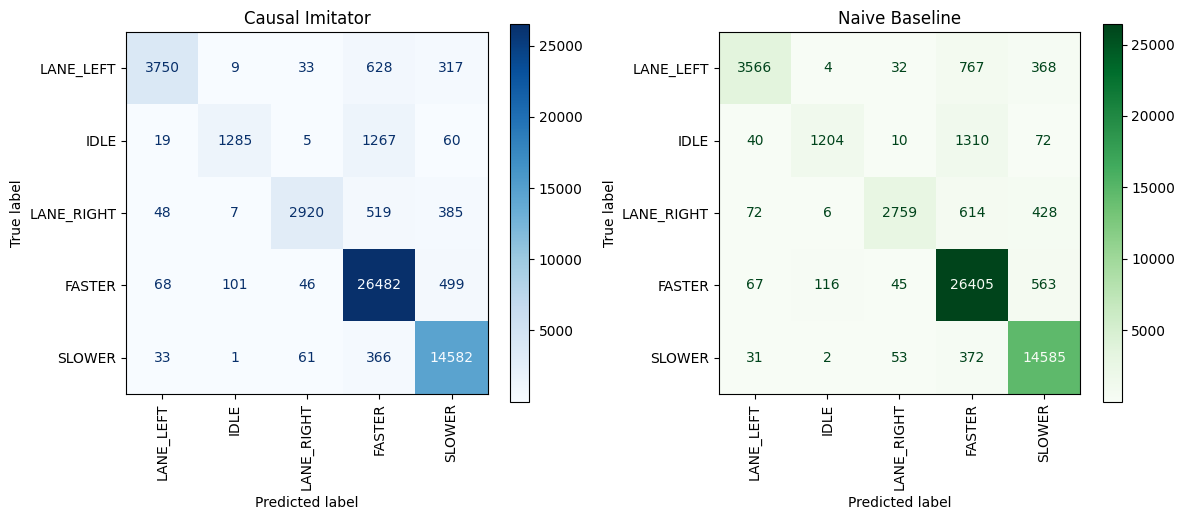

In [15]:
causal_records = collect_imitator_trajectories(env, causal_policies, train_eps, num_steps, seed)
naive_records = collect_imitator_trajectories(env, naive_policies, train_eps, num_steps, seed)

# Prepare label and display names
n_actions = env.env.action_space.n
labels = list(range(n_actions))
action_names = list(env.env.unwrapped.action_type.actions.keys())

# Gather true actions once
y_true = []
for r in records:
    y_true.append(r['action'])

# Gather predictions for causal and naive
y_pred_causal = []
y_pred_naive  = []
for r in records:
    t = r['step']
    key = f'X{t}'
    # causal
    if key in causal_policies:
        y_pred_causal.append(causal_policies[key](r['obs']))
    else:
        y_pred_causal.append(-1)  # or some placeholder
    # naive
    if key in naive_policies:
        y_pred_naive.append(naive_policies[key](r['obs']))
    else:
        y_pred_naive.append(-1)

# Compute confusion matrices (we’ll ignore the placeholder label -1)
cm_causal = confusion_matrix(y_true, y_pred_causal, labels=labels)
cm_naive  = confusion_matrix(y_true, y_pred_naive,  labels=labels)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

action_names = [env.env._meta_actions.ACTIONS_ALL[a] for a in action_names]

disp1 = ConfusionMatrixDisplay(cm_causal, display_labels=action_names)
disp1.plot(ax=ax1, cmap='Blues', xticks_rotation='vertical')
ax1.set_title("Causal Imitator")

disp2 = ConfusionMatrixDisplay(cm_naive, display_labels=action_names)
disp2.plot(ax=ax2, cmap='Greens', xticks_rotation='vertical')
ax2.set_title("Naive Baseline")

plt.tight_layout()
plt.show()

In [20]:
from collections import defaultdict

def avg_steps(records):
    steps = defaultdict(int)
    for r in records:
        ep = r['episode']
        steps[ep] += 1

    if not steps:
        return 0.0
    
    return sum(steps.values()) / len(steps)

print(avg_steps(records))
print(avg_steps(causal_records))
print(avg_steps(naive_records))

53.491
34.446
31.556


Expert Filtered ([('W', 1)]): {3: 0.481637405947689, 4: 0.2757076316732354, 1: 0.07640630598351845, 2: 0.07479398065209603, 0: 0.09145467574346113}
Expert Filtered ([('W', 0)]): {3: 0.5154865688567581, 0: 0.08779266189429914, 4: 0.2826800859971177, 1: 0.04212441231365322, 2: 0.07191627093817185}
Causal Filtered ([('W', 1)]): {3: 0.5838561271434546, 4: 0.246619266694549, 1: 0.025791161299316884, 2: 0.06287466889725359, 0: 0.0808587759654259}
Causal Filtered ([('W', 0)]): {0: 0.07835588310783559, 3: 0.5950940490595094, 4: 0.2518974810251898, 2: 0.05653943460565394, 1: 0.018113152201811315}
Naive Filtered ([('W', 1)]): {3: 0.6000899685110211, 4: 0.21172589593642224, 1: 0.03733693207377418, 2: 0.06492727545359124, 0: 0.08591992802519119}
Naive Filtered ([('W', 0)]): {3: 0.6221320368063648, 0: 0.07996142564391047, 2: 0.05894643789930486, 4: 0.21931128701731828, 1: 0.019648812633101618}


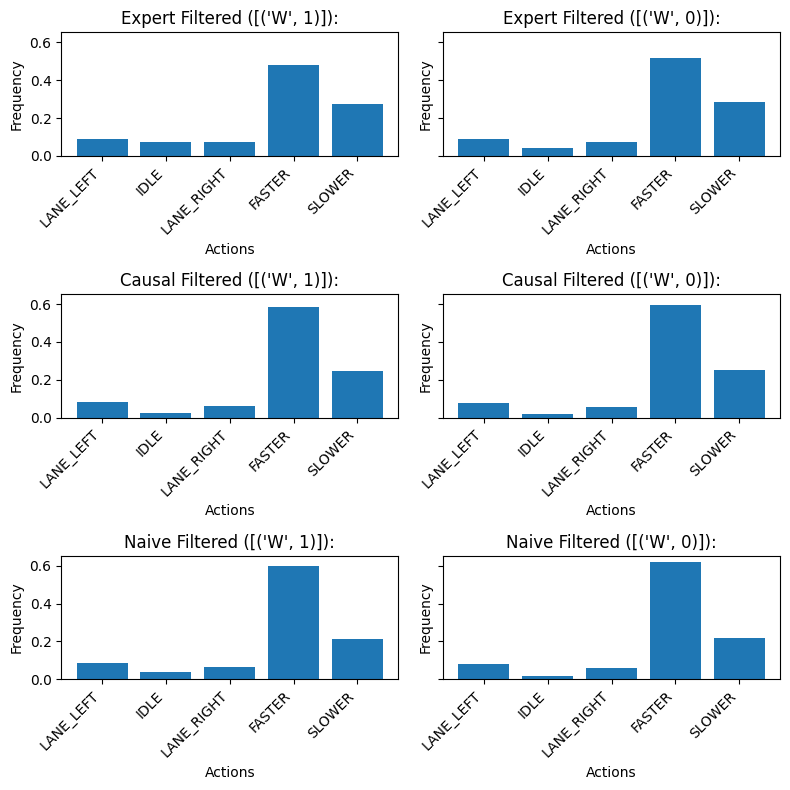

In [106]:
from collections import Counter

def filtered(records, state: List[Tuple[str, int]]):
    filtered_records = []
    for r in records:
        for var, val in state:
            index = -1 if var in ('X', 'Y') else -2 # X and Y have one less entry in the info
            loc = 'obs' if var in env.env.observed_unobserved_vars[0] else 'info'

            if -index <= len(r[loc][var]) and r[loc][var][index] == val:
                filtered_records.append(r)

    return filtered_records

# Prepare data for plotting
labels = list(range(env.env.action_space.n))
action_names = list(env.env.unwrapped.action_type.actions.keys())
action_names = [env.env._meta_actions.ACTIONS_ALL[a] for a in action_names]

state1 = [('W', 1)]
state0 = [('W', 0)]

expert_filtered1 = filtered(records, state1)
expert_filtered0 = filtered(records, state0)
causal_filtered1 = filtered(causal_records, state1)
causal_filtered0 = filtered(causal_records, state0)
naive_filtered1 = filtered(naive_records, state1)
naive_filtered0 = filtered(naive_records, state0)

# Count actions for each filtered result
expert_counts1 = Counter(r['action'] for r in expert_filtered1)
expert_counts0 = Counter(r['action'] for r in expert_filtered0)
causal_counts1 = Counter(r['action'] for r in causal_filtered1)
causal_counts0 = Counter(r['action'] for r in causal_filtered0)
naive_counts1 = Counter(r['action'] for r in naive_filtered1)
naive_counts0 = Counter(r['action'] for r in naive_filtered0)

# Normalize counts
total_expert1 = sum(expert_counts1.values())
total_expert0 = sum(expert_counts0.values())
total_causal1 = sum(causal_counts1.values())
total_causal0 = sum(causal_counts0.values())
total_naive1 = sum(naive_counts1.values())
total_naive0 = sum(naive_counts0.values())

expert_counts1 = {k: v / total_expert1 for k, v in expert_counts1.items()}
expert_counts0 = {k: v / total_expert0 for k, v in expert_counts0.items()}
causal_counts1 = {k: v / total_causal1 for k, v in causal_counts1.items()}
causal_counts0 = {k: v / total_causal0 for k, v in causal_counts0.items()}
naive_counts1 = {k: v / total_naive1 for k, v in naive_counts1.items()}
naive_counts0 = {k: v / total_naive0 for k, v in naive_counts0.items()}

print(f'Expert Filtered ({state1}):', expert_counts1)
print(f'Expert Filtered ({state0}):', expert_counts0)
print(f'Causal Filtered ({state1}):', causal_counts1)
print(f'Causal Filtered ({state0}):', causal_counts0)
print(f'Naive Filtered ({state1}):', naive_counts1)
print(f'Naive Filtered ({state0}):', naive_counts0)

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharey=True)

# Plot each distribution
axes[0, 0].bar(action_names, [expert_counts1.get(a, 0) for a in labels])
axes[0, 0].set_title(f'Expert Filtered ({state1}):')
axes[0, 1].bar(action_names, [expert_counts0.get(a, 0) for a in labels])
axes[0, 1].set_title(f'Expert Filtered ({state0}):')

axes[1, 0].bar(action_names, [causal_counts1.get(a, 0) for a in labels])
axes[1, 0].set_title(f'Causal Filtered ({state1}):')
axes[1, 1].bar(action_names, [causal_counts0.get(a, 0) for a in labels])
axes[1, 1].set_title(f'Causal Filtered ({state0}):')

axes[2, 0].bar(action_names, [naive_counts1.get(a, 0) for a in labels])
axes[2, 0].set_title(f'Naive Filtered ({state1}):')
axes[2, 1].bar(action_names, [naive_counts0.get(a, 0) for a in labels])
axes[2, 1].set_title(f'Naive Filtered ({state0}):')

# Adjust layout
for ax in axes.flat:
    ax.set_xlabel("Actions")
    ax.set_ylabel("Frequency")
    ax.set_xticks(action_names)
    ax.set_xticklabels(action_names, rotation=45, ha="right")

plt.tight_layout()
plt.show()

Expert Variation: {0: 0.0036620138491619825, 1: 0.034281893669865234, 2: 0.002877709713924176, 3: 0.03384916290906914, 4: 0.006972454323882271}
Causal Variation: {0: 0.002502892857590311, 1: 0.007678009097505569, 2: 0.006335234291599642, 3: 0.011237921916054772, 4: 0.005278214330640768}
Naive Variation: {0: 0.00595850238128072, 1: 0.01768811944067256, 2: 0.005980837554286383, 3: 0.02204206829534361, 4: 0.007585391080896037}


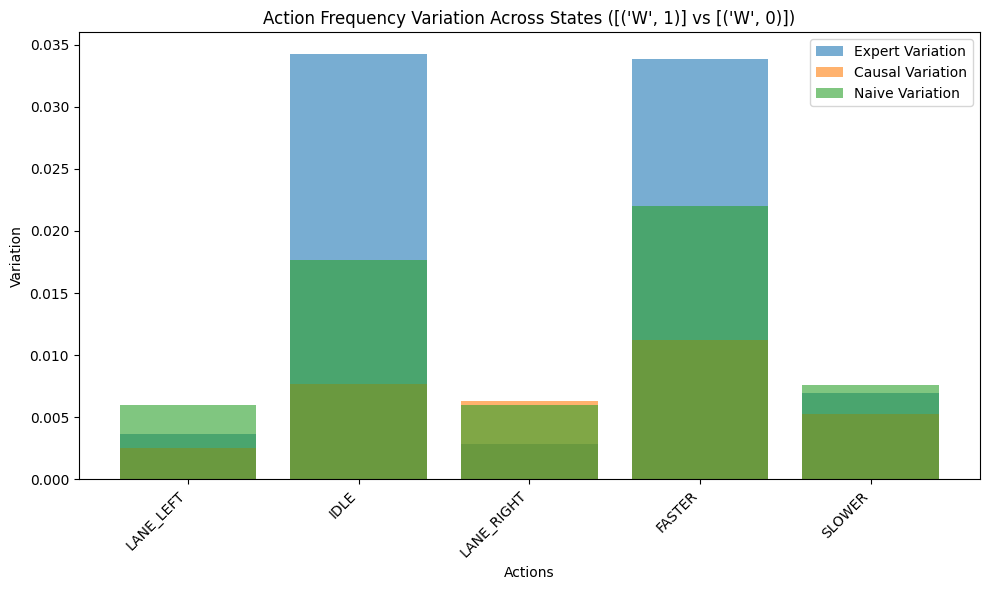

In [108]:
def calculate_variation(counts1, counts0, labels):
    variation = {}
    for label in labels:
        freq1 = counts1.get(label, 0)
        freq0 = counts0.get(label, 0)
        variation[label] = abs(freq1 - freq0)
    return variation

# Compute variations
expert_variation = calculate_variation(expert_counts1, expert_counts0, labels)
causal_variation = calculate_variation(causal_counts1, causal_counts0, labels)
naive_variation = calculate_variation(naive_counts1, naive_counts0, labels)

# Print variations
print("Expert Variation:", expert_variation)
print("Causal Variation:", causal_variation)
print("Naive Variation:", naive_variation)

# Plot variations
plt.figure(figsize=(10, 6))
x_labels = [action_names[label] for label in labels]

plt.bar(x_labels, [expert_variation[label] for label in labels], alpha=0.6, label='Expert Variation')
plt.bar(x_labels, [causal_variation[label] for label in labels], alpha=0.6, label='Causal Variation')
plt.bar(x_labels, [naive_variation[label] for label in labels], alpha=0.6, label='Naive Variation')

plt.xticks(x_labels)

plt.xlabel('Actions')
plt.ylabel('Variation')
plt.title(f'Action Frequency Variation Across States ({state1} vs {state0})')
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

In [118]:
causal_correct = sum(cm_causal[i, i] for i in range(len(labels)))
naive_correct  = sum(cm_naive[i, i] for i in range(len(labels)))

print(f"Causal Correct Predictions: {causal_correct}")
print(f"Naive Correct Predictions: {naive_correct}")

causal_incorrect = sum(cm_causal[i, j] for i in range(len(labels)) for j in range(len(labels)) if i != j)
naive_incorrect  = sum(cm_naive[i, j] for i in range(len(labels)) for j in range(len(labels)) if i != j)

print(f"Causal Incorrect Predictions: {causal_incorrect}")
print(f"Naive Incorrect Predictions: {naive_incorrect}")

causal_correct / naive_correct, causal_incorrect / naive_incorrect

Causal Correct Predictions: 49019
Naive Correct Predictions: 48519
Causal Incorrect Predictions: 4472
Naive Incorrect Predictions: 4972


(1.0103052412456976, 0.8994368463395012)